In [1]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings, useful for cleaner output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_curve, auc, roc_curve


In [2]:
# Simulate Transaction Time Series Data
np.random.seed(123)

# Simulate 200 transaction records with hourly timestamps
timestamps = pd.date_range('2023-01-01', periods=200, freq='H')

# Generate random transaction amounts around 100 with some standard deviation
transaction_amounts = np.random.normal(loc=100, scale=20, size=200)

# Introduce anomalies: Add a few random large and small transaction outliers
outlier_indices = np.random.choice(range(200), size=5, replace=False)  # Select 5 random indices for anomalies
transaction_amounts[outlier_indices] = np.random.choice([500, 10, 2000], size=5)  # Assign extreme values

# Create DataFrame
data = pd.DataFrame({
    'timestamp': timestamps,
    'transaction_amount': transaction_amounts
})
data.set_index('timestamp', inplace=True)

# Create 'true_anomaly' column that marks injected anomalies
data['true_anomaly'] = data.index.isin(timestamps[outlier_indices])

data.head()

,transaction_amount,true_anomaly
timestamp,,
2023-01-01 00:00:00,78.287388,False
2023-01-01 01:00:00,119.946909,False
2023-01-01 02:00:00,105.659570,False
2023-01-01 03:00:00,69.874106,False
2023-01-01 04:00:00,88.427995,False


In [3]:
# show the true anomaly
data[ data['true_anomaly'] == True]

,transaction_amount,true_anomaly
timestamp,,
2023-01-01 11:00:00,500.0,True
2023-01-03 19:00:00,10.0,True
2023-01-05 02:00:00,10.0,True
2023-01-05 11:00:00,500.0,True
2023-01-08 17:00:00,2000.0,True


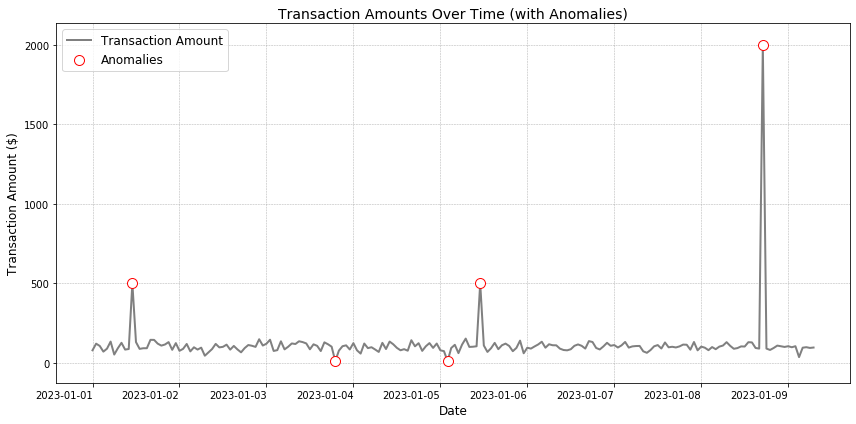

In [4]:
# Visualize the Transaction Time Series Data 
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['transaction_amount'], label='Transaction Amount', color='gray', lw=2)

anomalies = data[data['true_anomaly']]
plt.scatter(anomalies.index, anomalies['transaction_amount'], color='white', label='Anomalies', zorder=5, s=100, edgecolors='red')
plt.title('Transaction Amounts Over Time (with Anomalies)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Amount ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()


In [5]:
# Preprocess Data for Anomaly Detection

# standardize the transaction amounts
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['transaction_amount']])

#  Apply Isolation Forest for Anomaly Detection
model = IsolationForest(
    n_estimators=100,          # Number of trees in the forest
    contamination=0.03,        # Contamination factor (expected percentage of anomalies)
    max_samples=256,           # Number of samples to train each tree on (use a fraction if dataset is large)
    random_state=123,          # Ensure reproducibility
    max_features=1.0,          # Use all features 
    bootstrap=False,           # Use bootstrapping (False for faster training)
    n_jobs=-1,                 # Use all cores for parallel computation
    warm_start=False           # Option to add data incrementally (can be set True for large datasets)
)

anomalies = model.fit_predict(data_scaled)

# Convert the anomaly labels (-1 for anomaly, 1 for normal)
data['anomaly'] = anomalies
data['anomaly'] = data['anomaly'].map({1: False, -1: True})

data.head()

,transaction_amount,true_anomaly,anomaly
timestamp,,,
2023-01-01 00:00:00,78.287388,False,False
2023-01-01 01:00:00,119.946909,False,False
2023-01-01 02:00:00,105.659570,False,False
2023-01-01 03:00:00,69.874106,False,False
2023-01-01 04:00:00,88.427995,False,False


In [6]:
# Analyze the Detected Anomalies
anomalous_transactions = data[data['anomaly'] == True]
print("\nAnomalous Transactions Detected:")
# display(anomalous_transactions[['transaction_amount']])
anomalous_transactions


Anomalous Transactions Detected:


,transaction_amount,true_anomaly,anomaly
timestamp,,,
2023-01-01 11:00:00,500.0000,True,True
2023-01-03 19:00:00,10.0000,True,True
2023-01-05 02:00:00,10.0000,True,True
2023-01-05 11:00:00,500.0000,True,True
2023-01-08 17:00:00,2000.0000,True,True
2023-01-09 03:00:00,35.3789,False,True


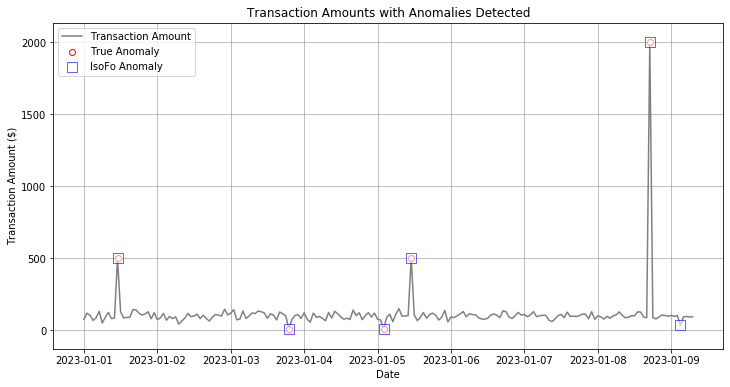

In [7]:
# Visualize the Anomalies in the Transaction Data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['transaction_amount'], label='Transaction Amount', color='gray')
plt.scatter(data.index[data['true_anomaly']], data['transaction_amount'][data['true_anomaly']], color='white',
            label='True Anomaly', zorder=5, edgecolors='red')
plt.scatter(data.index[data['anomaly']], data['transaction_amount'][data['anomaly']], color='white', label='IsoFo Anomaly',
            zorder=5, s=100, edgecolors='blue', marker='s', alpha=0.6)
plt.title('Transaction Amounts with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('Transaction Amount ($)')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# Compute Z-Score for Anomaly Detection

# Calculate mean and standard deviation
mean = data['transaction_amount'].mean()
std_dev = data['transaction_amount'].std()

# Calculate the Z-Score for each transaction
data['z_score'] = (data['transaction_amount'] - mean) / std_dev

# Identify Anomalies based on Z-Score Threshold (e.g., |Z| > 2)
threshold = 2  # Common threshold for anomaly detection (3 standard deviations)
data['z_anomaly'] = data['z_score'].apply(lambda x: abs(x) > threshold)
# data['z_anomaly'] = data['z_score'].abs() > threshold
data.head()

,transaction_amount,true_anomaly,anomaly,z_score,z_anomaly,lof_anomaly,day_of_week,month
timestamp,,,,,,,,
2023-01-01 00:00:00,78.287388,False,False,-0.245747,False,False,6,1
2023-01-01 01:00:00,119.946909,False,False,0.048228,False,False,6,1
2023-01-01 02:00:00,105.659570,False,False,-0.052592,False,False,6,1
2023-01-01 03:00:00,69.874106,False,False,-0.305116,False,False,6,1
2023-01-01 04:00:00,88.427995,False,False,-0.174189,False,False,6,1


In [22]:
# Analyze the Detected Anomalies
# Print timestamps and amounts of detected anomalies
anomalous_transactions = data[data['z_anomaly'] == True]
print("\nAnomalous Transactions Detected:")
display(anomalous_transactions[['transaction_amount', 'z_score', 'z_anomaly']])


Anomalous Transactions Detected:


,transaction_amount,z_score,z_anomaly
timestamp,,,
2023-01-01 11:00:00,500.0,2.730113,True
2023-01-05 11:00:00,500.0,2.730113,True
2023-01-08 17:00:00,2000.0,13.315023,True


In [24]:
# Compare detected anomalies using both methods
compdata = data[data['anomaly'] == True].loc[:,['anomaly','true_anomaly', 'z_anomaly','transaction_amount']]
compdata

,anomaly,true_anomaly,z_anomaly,transaction_amount
timestamp,,,,
2023-01-01 11:00:00,True,True,True,500.0000
2023-01-03 19:00:00,True,True,False,10.0000
2023-01-05 02:00:00,True,True,False,10.0000
2023-01-05 11:00:00,True,True,True,500.0000
2023-01-08 17:00:00,True,True,True,2000.0000
2023-01-09 03:00:00,True,False,False,35.3789


In [25]:
# Compare anomalies detected by Isolation Forest and Z-Score
compdata[compdata['anomaly'] != compdata['z_anomaly']]

,anomaly,true_anomaly,z_anomaly,transaction_amount
timestamp,,,,
2023-01-03 19:00:00,True,True,False,10.0000
2023-01-05 02:00:00,True,True,False,10.0000
2023-01-09 03:00:00,True,False,False,35.3789


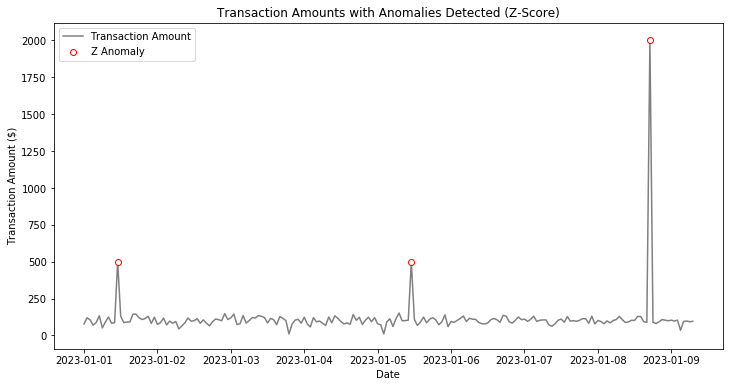

In [26]:
# Visualize the Anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['transaction_amount'], label='Transaction Amount', color='gray')
plt.scatter(data.index[data['z_anomaly']], data['transaction_amount'][data['z_anomaly']], color='white', 
            label='Z Anomaly', zorder=5, edgecolors='red')
plt.title('Transaction Amounts with Anomalies Detected (Z-Score)')
plt.xlabel('Date')
plt.ylabel('Transaction Amount ($)')
plt.legend()
plt.show()

In [27]:
# Apply Local Outlier Factor (LOF)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['transaction_amount']])

# Apply Local Outlier Factor (LOF) for anomaly detection with more options
lof = LocalOutlierFactor(
    n_neighbors=20,           # Number of neighbors to consider (higher for larger datasets)
    contamination=0.03,       # Proportion of expected outliers (tune this value)
    metric='euclidean',       # Distance metric: 'euclidean', 'manhattan', or others (can tune based on data)
    p=2,                      # Power parameter for the Minkowski distance (use 2 for Euclidean, 1 for Manhattan)
    algorithm='auto',         # Algorithm to compute nearest neighbors: 'auto', 'ball_tree', 'kd_tree', 'brute'
    leaf_size=30,             # Leaf size for tree-based algorithms ('ball_tree', 'kd_tree')
    n_jobs=-1                 # Use all available CPU cores for parallel computation
)

# Fit the model and detect anomalies (-1 indicates anomaly, 1 indicates normal)
lof_anomalies = lof.fit_predict(data_scaled)

# Add the results to the DataFrame (True for anomalies, False for normal)
data['lof_anomaly'] = lof_anomalies == -1  # Anomalies are labeled -1 by LOF

# Display anomalous transactions based on LOF
lof_anomalous_transactions = data[data['lof_anomaly'] == True]
display(lof_anomalous_transactions[['transaction_amount', 'true_anomaly', 'anomaly', 'lof_anomaly']])

,transaction_amount,true_anomaly,anomaly,lof_anomaly
timestamp,,,,
2023-01-01 11:00:00,500.0000,True,True,True
2023-01-03 19:00:00,10.0000,True,True,True
2023-01-05 02:00:00,10.0000,True,True,True
2023-01-05 11:00:00,500.0000,True,True,True
2023-01-08 17:00:00,2000.0000,True,True,True
2023-01-09 03:00:00,35.3789,False,True,True


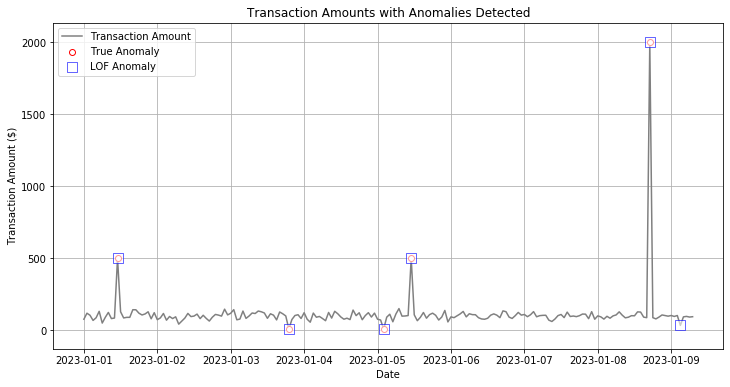

In [28]:
# Visualize the Anomalies in the Transaction Data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['transaction_amount'], label='Transaction Amount', color='gray')
plt.scatter(data.index[data['true_anomaly']], data['transaction_amount'][data['true_anomaly']], color='white',
            label='True Anomaly', zorder=5, edgecolors='red')
plt.scatter(data.index[data['lof_anomaly']], data['transaction_amount'][data['lof_anomaly']], color='white', label='LOF Anomaly',
            zorder=5, s=100, edgecolors='blue', marker='s', alpha=0.6)
plt.title('Transaction Amounts with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('Transaction Amount ($)')
plt.grid(True)
plt.legend()
plt.show()

Model Evaluation Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       195
        True       0.83      1.00      0.91         5

    accuracy                           0.99       200
   macro avg       0.92      1.00      0.95       200
weighted avg       1.00      0.99      1.00       200



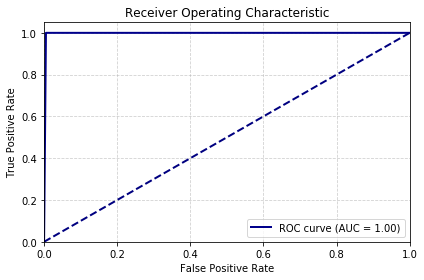

In [29]:
# Evaluate model performance (Precision, Recall, F1-Score)

# Print detailed classification report
print("Model Evaluation Report:")
print(classification_report(data['true_anomaly'], data['lof_anomaly']))

# Plot ROC curve to evaluate model performance in terms of AUC
fpr, tpr, _ = roc_curve(data['true_anomaly'], data['lof_anomaly'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Time-Based Analysis of Anomalies

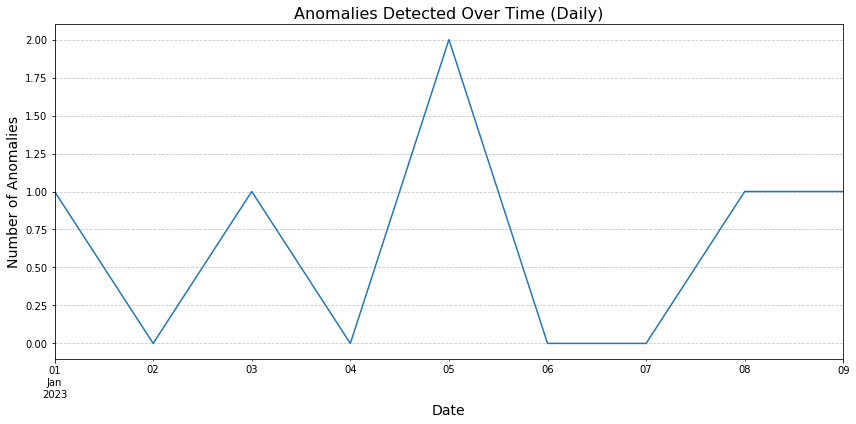

In [30]:
# Count anomalies over time (e.g., hourly or daily)
anomalies_over_time = data['anomaly'].resample('D').sum()  # Daily count of anomalies
anomalies_over_time.plot(figsize=(12, 6), title='Anomalies Detected Over Time')
plt.title('Anomalies Detected Over Time (Daily)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Anomalies', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Anomaly Severity

In [31]:
# Calculate the deviation from the mean for anomalies
deviation_from_mean = data.loc[data['anomaly'], 'transaction_amount'] - data['transaction_amount'].mean()
print("Deviation of Anomalous Transactions from Mean:\n")
display(deviation_from_mean)

Deviation of Anomalous Transactions from Mean:



timestamp
2023-01-01 11:00:00     386.887522
2023-01-03 19:00:00    -103.112478
2023-01-05 02:00:00    -103.112478
2023-01-05 11:00:00     386.887522
2023-01-08 17:00:00    1886.887522
2023-01-09 03:00:00     -77.733578
Name: transaction_amount, dtype: float64

Correlation with Other Features

In [17]:
# check for 'user_id': if certain users are more likely to generate anomalies
# Count anomalies by user

# anomalies_by_user = data[data['anomaly']].groupby('user_id').size()

# Plot anomalies by user

# anomalies_by_user.plot(kind='bar', figsize=(12, 6), title='Anomalies by User')
# plt.ylabel('Anomalies Count')
# plt.show()

Impact of Anomalies on Business Metrics

In [32]:
# Summarize the impact of anomalies on total transaction amount
normal_transactions = data[data['anomaly'] == False]
anomalous_transactions = data[data['anomaly'] == True]

total_normal = normal_transactions['transaction_amount'].sum()
total_anomalous = anomalous_transactions['transaction_amount'].sum()

print(f"Total Normal Transaction Amount: ${total_normal:.2f}")
print(f"Total Anomalous Transaction Amount: ${total_anomalous:.2f}")

Total Normal Transaction Amount: $19567.12
Total Anomalous Transaction Amount: $3055.38


Visualizing Anomalies with a Histogram

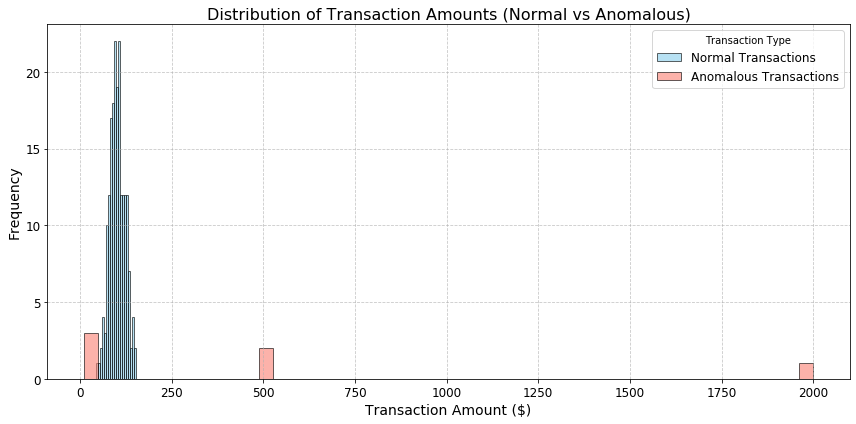

In [37]:
# Visualize the distribution of normal vs anomalous transactions
plt.figure(figsize=(12, 6))

# Plot normal and anomalous transactions
plt.hist(data[~data['anomaly']]['transaction_amount'], bins=20, alpha=0.6, label='Normal Transactions', color='skyblue', edgecolor='black')
plt.hist(data[data['anomaly']]['transaction_amount'], bins=50, alpha=0.6, label='Anomalous Transactions', color='salmon', edgecolor='black')

plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Distribution of Transaction Amounts (Normal vs Anomalous)', fontsize=16)
plt.xlabel('Transaction Amount ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Transaction Type', loc='upper right', fontsize=12)

# Format x-axis to show better tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  
plt.show()

Seasonality or Trend Analysis

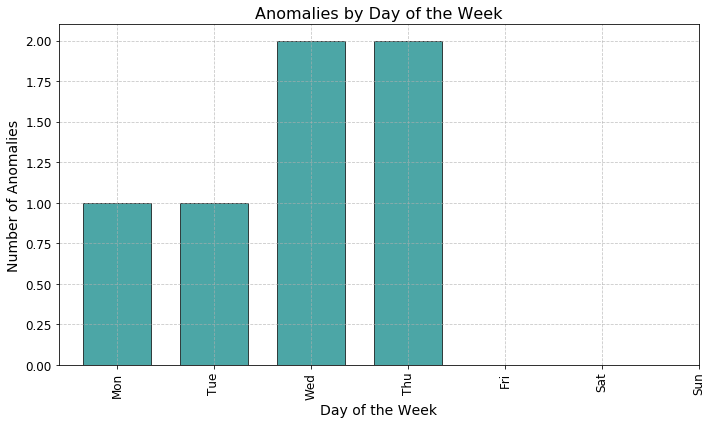

In [38]:
# Extract day of the week and month
data['day_of_week'] = data.index.dayofweek  # Monday=0, Sunday=6
data['month'] = data.index.month

# Count anomalies by day of the week
anomalies_by_day = data[data['anomaly']].groupby('day_of_week').size()

# Plot anomalies by day of the week
plt.figure(figsize=(10, 6))
anomalies_by_day.plot(kind='bar', color='teal', alpha=0.7, edgecolor='black', width=0.7)

plt.title('Anomalies by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Anomalies', fontsize=14)

# Customize x-axis ticks to show day names
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
